In [1]:
from sympy import *
from matplotlib import pyplot as plt
import pandas as pd

In [46]:
def simult(t1=Symbol('t_1'),
           t2=Symbol('t_2'),
           l=Symbol('l'),
           q=Symbol('q'),
           m1=Symbol('m_1'),
           m2=Symbol('m_2'),
           b1=Symbol('b_1'),
           b2=Symbol('b_2'),
           sol=-1):
    
    #profits
    pi1 = S(.5)*( (t2-t1)/S(3) +q)*(1 + (t2-t1)/(S(3)*q) )
    pi2 = S(.5)*( (t1-t2)/S(3) +q)*(1 + (t1-t2)/(S(3)*q) )
    #nash bargaining objectives
    v1 = (pi1 - pi1.subs(t1,l) )**(b1) * (m1*t1 +m2*t2)**(S(1)-b1)
    v2 = (pi2 - pi2.subs(t2,l) )**(b2) * (m1*t1 +m2*t2)**(S(1)-b2)
    #simultaneous bargaining
    v1_foc = diff(v1,t1)
    v2_foc = diff(v2,t2)
    #solve for t2 as a function of t1
    t2_param = solve(v2_foc,t2)
    #print 't2_param: %s\n'% t2_param
    
    #focus on positive solution
    t2_param = t2_param[sol]

    #substitute back into foc
    v1_foc1 = v1_foc.subs(t2,t2_param)
    t1_param = solve(v1_foc1,t1)
    #print 't1_param: %s\n'% t1_param
    
    t1_param = t1_param[min(len(t1_param)-1,1)] 
   
    #sovle for t2
    t2_param = t2_param.subs(t1, t1_param)

    #solve for pi
    pi1_param = pi1.subs({t1:t1_param, t2:t2_param})
    pi2_param = pi2.subs({t1:t1_param, t2:t2_param})
    
    return (l,q,m1,m2,b1,b2,t1_param,t2_param,pi1_param,pi2_param)

print simult(l = 4, q = 1, m1 = .5, m2 = .5, b1 = .5, b2 = .5, sol = 0)

(4, 1, 0.5, 0.5, 0.5, 0.5, 0.744562646538029, 0.744562646538029, 0.500000000000000, 0.500000000000000)


In [3]:
def seq(t1=Symbol('t_1'),
           t2=Symbol('t_2'),
           l=Symbol('l'),
           q=Symbol('q'),
           m1=Symbol('m_1'),
           m2=Symbol('m_2'),
           b1=Symbol('b_1'),
           b2=Symbol('b_2'),
           sol=-1):
    #profits
    pi1 = .5*( (t2-t1)/3 +q)*(1 + (t2-t1)/(3*q) )
    pi2 = .5*( (t1-t2)/3 +q)*(1 + (t1-t2)/(3*q) )

    #use SPE/backward induction to solve game
    v2 = (pi2 - pi2.subs(t2,l) ) * (m1*t1 +m2*t2)
    v2_foc = diff(v2,t2)

    #solve for t1 as a function of t2
    h1 = solve(v2_foc,t2,force=True)
    #print 'h1: %s\n'%h1
    
    h1 = h1[-1]
    h1 = simplify(h1)
    
    #susbitute h1 for t2, then substitute l into the second term for t1
    pi1_h = pi1.subs(t2,h1)
    pi1_l = pi1_h.subs(t1,l)
    v1 = (pi1.subs(t2,h1) - pi1_l ) * (m1*t1 + m2*h1)
    v1_foc = diff(v1,t1)
    t1_param = solve(v1_foc,t1,rational=False,force=True)

    #print 't1_param: %s\n'%t1_param
    t1_param = t1_param[-1]
    
    t2_param = h1.subs(t1,t1_param) 
    pi1_param = pi1.subs({t1:t1_param, t2:t2_param})
    pi2_param = pi2.subs({t1:t1_param, t2:t2_param})
    
    return (l,q,m1,m2,b1,b2,t1_param,t2_param,pi1_param,pi2_param)

print seq(l = 5, q = 1, m1 = .5, m2 = .5, b1 = .5, b2 = .5, sol = -1)

(5, 1, 0.5, 0.5, 0.5, 0.5, 2.71029656017669, 5.74009595696966, 2.01991559808694, 4.93335582902741e-5)


In [4]:
def l_plotter(game, ranger, scaler, args):
    q0, m10, m20, b10, b20, sol0 = args
    result = [] 
    for l in ranger: 
        l = l/scaler 
        result.append(game(l = l ,q = q0, m1 = m10, m2 = m20, b1 = b10, b2 = b20, sol=sol0)) 
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2']) 
    return result


def q_plotter(game, ranger, scaler, args): 
    l0, m10, m20, b10, b20, sol0 = args 
    result = [] 
    for q in ranger: 
        q = q/scaler 
        result.append(game(l = l0 ,q = q, m1 = m10, m2 = m20, b1 = b10, b2 = b20, sol=sol0))
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2'])
    return result


In [5]:
def quick_plot(frame,ptype,fname):
    #plot pi
    fig = plt.figure()
    fig.suptitle('pi  vs %s'%ptype)
    plt.ylabel('pi(%s)'%ptype)
    plt.xlabel(ptype)
    plt.plot(frame[ptype] ,frame['pi_1'], color='red')
    plt.plot(frame[ptype] ,frame['pi_2'] ,color = 'blue')
    fig.savefig('plots/%s_pi_%s'%(fname,ptype))
    
    #plot theta
    fig = plt.figure()
    fig.suptitle('theta  vs %s'%ptype)
    plt.ylabel('theta(%s)'%ptype)
    plt.xlabel(ptype)
    plt.plot(frame[ptype] ,frame['theta_1'], color='red')
    plt.plot(frame[ptype] ,frame['theta_2'] ,color = 'blue')
    fig.savefig('plots/%s_theta_%s'%(fname,ptype))

In [32]:
# simultaneous, graph of l vs pi, graph of l theta
arg0 =  (1, .5,.5,.5,.5,-1)
simult1_l =  l_plotter(simult,range(1,30,1),10.0, arg0)

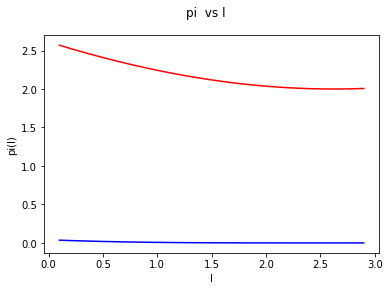

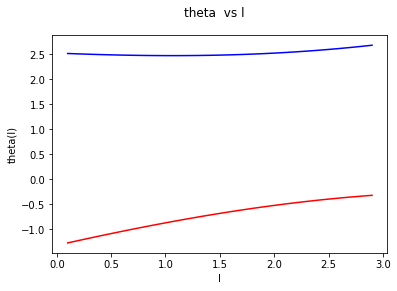

In [33]:
# simultaneous, graph of l vs pi, simultaneous, graph of l theta
simult1_l.to_csv('sheets/l_simult1.csv', sep=',')
quick_plot(simult1_l,'l','simult1')

In [57]:
# simultaneous (other solution), graph of l pi , graph of l theta
arg0 =  (1, .5,.5,.5,.5,0)
simult4_l =  l_plotter(simult,range(1,5),1, arg0)

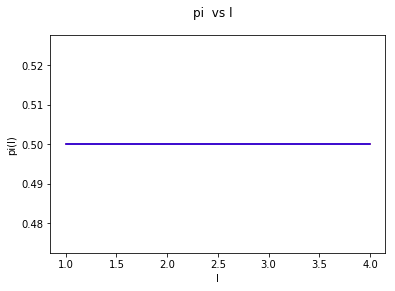

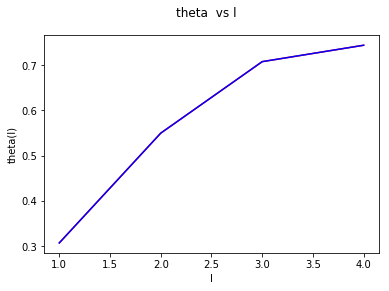

In [58]:
simult4_l.to_csv('sheets/l_simult4.csv', sep=',')
quick_plot(simult4_l,'l','simult4')

In [61]:
# simultaneous, graph of q pi, graph of q theta
arg0 =  (1, .5,.5,.5,.5,0)
simult1_q =  q_plotter(simult,range(1,15),1, arg0)

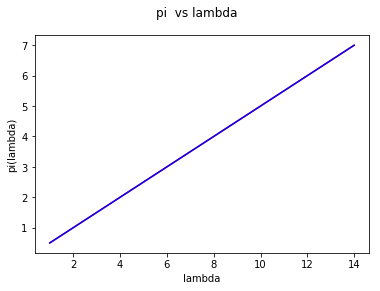

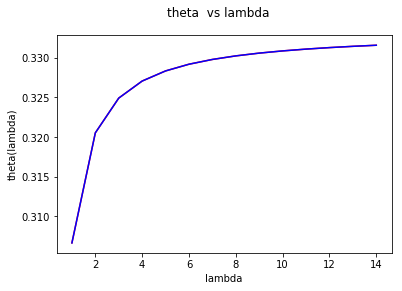

In [62]:
simult1_q.to_csv('sheets/lambda_simult1.csv', sep=',')
quick_plot(simult1_q,'lambda','simult1')

In [59]:
# simultaneous, graph of q pi, graph of q theta
arg0 =  (1, .5,.5,.5,.5,0)
simult3_q =  q_plotter(simult,range(1,30),10.0, arg0)

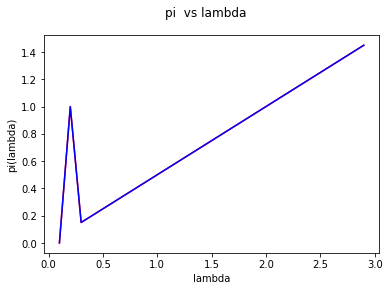

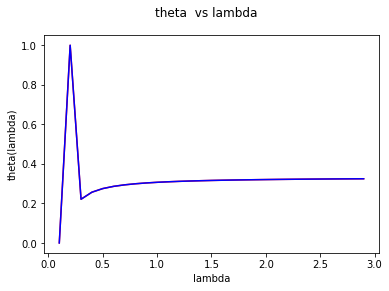

In [60]:
simult3_q.to_csv('sheets/lambda_simult3.csv', sep=',')
quick_plot(simult3_q,'lambda','simult3')

In [41]:
#sequential graph l vs pi, seq graph l vs theta
arg0 =  (1, .5,.5,.5,.5,-1)
seq1_l =  l_plotter(seq,range(1,30),10.0, arg0)

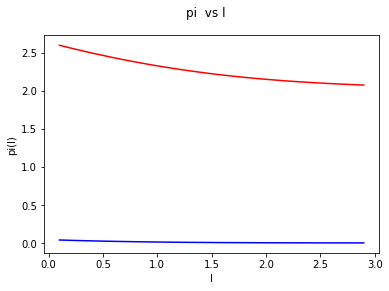

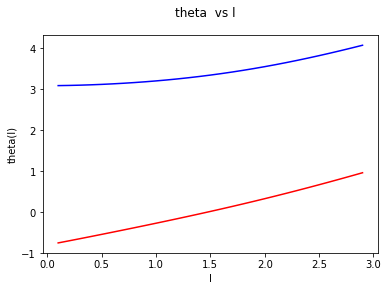

In [7]:
seq1_l.to_csv('sheets/l_seq1.csv', sep=',')
quick_plot(seq1_l,'l','seq1')

In [8]:
#seq graph q vs pi, seq graph q vs theta
arg0 =  (1, .5,.5,.5,.5,-1)
seq2_l =  l_plotter(seq,range(1,15),1, arg0)

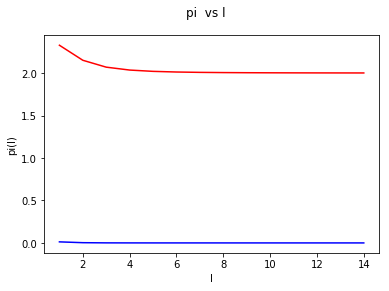

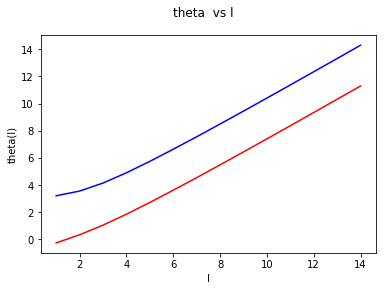

In [9]:
seq2_l.to_csv('sheets/l_seq2.csv', sep=',')
quick_plot(seq2_l,'l','seq2')

In [10]:
arg0 =  (6, .5,.5,.5,.5,-1)
seq1_q =  q_plotter(seq,range(1,30),10.0, arg0)

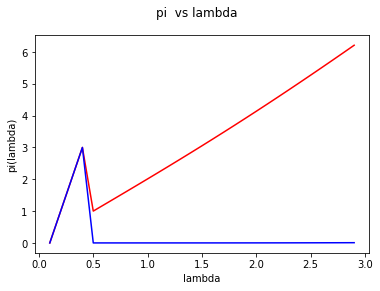

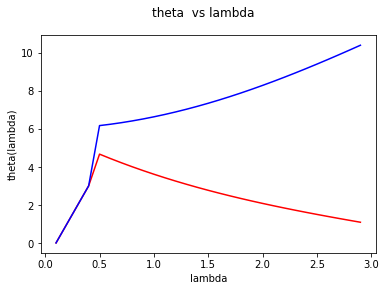

In [11]:
seq1_q.to_csv('sheets/lambda_seq1.csv', sep=',')
quick_plot(seq1_q,'lambda','seq1')

In [12]:
arg0 =  (6, .5,.5,.5,.5,-1)
seq2_q =  q_plotter(seq,range(1,15),1, arg0)

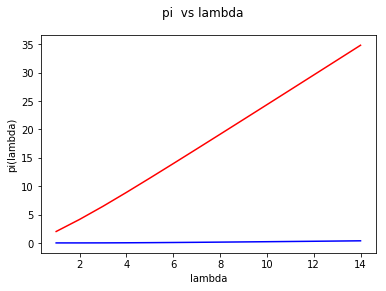

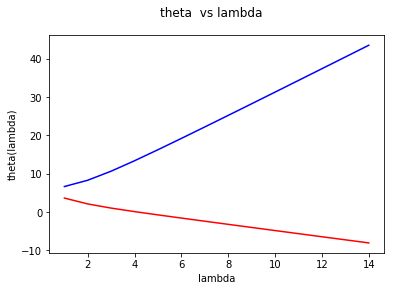

In [13]:
seq2_q.to_csv('sheets/lambda_seq2.csv', sep=',')
quick_plot(seq2_q,'lambda','seq2')